In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from quantecon.markov import DiscreteDP
from numba import jit

In [2]:
# parameters
rho = 0.1               # AR(1) correlation
sigma = 1.0             # AR(1) variant
delta = 0.05            # capital depreciation rate
alpha = 0.3             # Cobb-Douglas parameter
beta = 0.96             # discount factor
w = 5                   # wage rate if fixed. would be modified later     
k_init = 5              # initial capital if transform from worker to entrepreneur
z0 = 0                  # time 0 productivity shock
kmin = 0                # capital lower bound
kmax = 40               # capital upper bound
zmin = -4               # shock lower bound, see experiment below
zmax = 4                # shock upper bound, see experiment below
grid_size = 100         # basic grid size
ksize = grid_size
asize = grid_size
zsize = grid_size * 2
kgrid = np.linspace(kmin, kmax, ksize)
agrid = np.linspace(kmin, kmax, asize)  # worker's asset is treated equivalent to entrepreneur's capital
zgrid = np.linspace(zmin, zmax, zsize)
pi = alpha * ((1 - alpha) / w)**((1-alpha)/alpha)   # the derived parameter in entrepreneur dividend function

In [3]:
def simulate_shock(z0=z0, rho=rho, sigma=sigma, T=100):   # use the parameter defined globally above
    z = z0
    zs = [z0]
    for i in range(T):
        z = rho * z + sigma * np.random.normal()
        zs.append(z)
    return zs

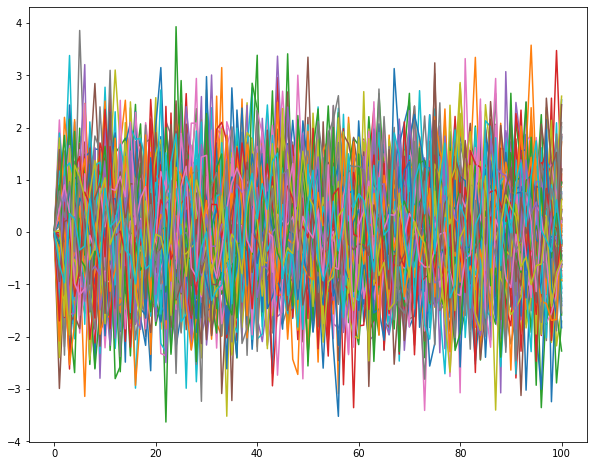

-3.6298872143787264 3.9294745741097956


In [4]:
N = 100
zmin, zmax = 0, 0
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(N):
    zs = simulate_shock()
    if zmin > min(zs): zmin = min(zs)
    if zmax < max(zs): zmax = max(zs)
    ax.plot(range(len(zs)), zs)
plt.show()
print(zmin, zmax)

In [9]:
class AiyagariChoice:
    
    def __init__(self, rho=rho, sigma=sigma, delta=delta, alpha=alpha, beta=beta, 
                 w=w, k_init=k_init, z0=z0, kmin=kmin, kmax=kmax, zmin=zmin, zmax=zmax, grid_size=grid_size):
        
        # store the parameters
        self.rho = rho
        self.sigma = sigma
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.w = w
        self.k_init = k_init
        self.z0 = z0
        self.pi = alpha * ((1 - alpha) / w)**((1-alpha)/alpha)
        
        self.ksize = grid_size
        self.asize = grid_size
        self.zsize = grid_size
        self.Esize = self.ksize * self.zsize
        self.Wsize = self.asize * self.zsize
        
        self.kgrid = np.linspace(kmin, kmax, self.ksize)
        self.agrid = np.linspace(kmin, kmax, self.asize)
        self.zgrid = np.linspace(zmin, zmax, self.zsize)
        
        self.shock_transition_matrix = np.zeros((self.zsize, self.zsize))   
        self.gen_shock_transition_matrix()
        
        # Build the array EQ and ER
        self.EQ = np.zeros((self.Esize, self.ksize, self.Esize))
        self.populate_EQ()
        self.ER = np.empty((self.Esize, self.ksize))
        self.ER.fill(-np.inf)
        self.populate_ER()
        
        
    def populate_EQ(self):
        for i in range(self.ksize):
            for j in range(self.ksize):
                self.EQ[i*self.zsize:(i+1)*self.zsize, j, j*self.zsize:(j+1)*self.zsize] = \
                self.shock_transition_matrix[:, :]
        
    
    def populate_ER(self):
        
        def get_c(k, next_k):
            d = np.exp(self.zgrid / self.alpha) * self.pi * k
            c = d + (1 - self.delta) * k - next_k
            return c
        
        @np.vectorize
        def u(c):
              return np.log(c) if c>0 else np.log(1e-10)
            
        for i in range(self.ksize):
            k = self.kgrid[i]
            for j in range(self.ksize):
                next_k = self.kgrid[j]
                c = get_c(k, next_k)
                if np.any(c>=0):
                    self.ER[i*self.zsize:(i+1)*self.zsize, j][c>=0] = u(c[c>=0])  # Utility

    # this function calculate the pdf of each grid point z' given the current z' index and normalize
    def conditional_probability(self, z_idx):
        z = self.zgrid[z_idx]
        mu = self.rho * z
        z_prime_dist = norm(mu, self.sigma)
        z_prime_pdf = z_prime_dist.pdf(self.zgrid)
        # normalize the pdf to be sum to 1
        z_prime_pdf /= z_prime_pdf.sum()
        return z_prime_pdf
    
    # this function calculate the pdf of each grid point z' from the ergodic distribution in W's problem
    def unconditional_probability(self):
        z_prime_dist = norm(0, np.sqrt(self.sigma**2 / (1 - self.rho)))
        z_prime_pdf = z_prime_dist.pdf(self.zgrid)
        z_prime_pdf /= z_prime_pdf.sum()
        return z_prime_pdf
       
    def gen_shock_transition_matrix(self):
        for i in range(self.zsize):
            self.shock_transition_matrix[i, :] = self.conditional_probability(i)
        

In [10]:
model = AiyagariChoice()

In [ ]:
ddp = DiscreteDP(model.ER, model.EQ, model.beta)
result = ddp.solve()